# CLIP-Dissect
**Keywords**: Neuron-level Interpretability, Network Dissection

**About the dataset**:

* We use the standard [CIFAR100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) here which contains 60k RGB images of size $32\times 32$ belonging to 100 classes.

**Agenda**:

* In this programming challenge, we will reproduce the results of Fig. 4 from [CLIP-Dissect](https://arxiv.org/pdf/2204.10965.pdf).
* In this particular experiment, the neurons of the last layer of an ImageNet1k-pretrained ResNet50 are labeled using the CIFAR100 dataset as the probing dataset.
* We give some starter code that installs required dependencies and clones the original code release and changes the directory to it, so that you can import any files from that folder.

**Note:**
* A note on working with GPU:
  * Take care that whenever declaring new tensors, set `device=device` in parameters.
  * You can also move a declared torch tensor/model to device using `.to(device)`.
  * To move a torch model/tensor to cpu, use `.to('cpu')`
  * Keep in mind that all the tensors/model involved in a computation have to be on the same device (CPU/GPU).
* Run all the cells in order.
* **Do not edit** the cells marked with !!DO NOT EDIT!!
* Only **add your code** to cells marked with !!!! YOUR CODE HERE !!!!
* Do not change variable names, and use the names which are suggested.

In [ ]:
# !!DO NOT EDIT!!
!git clone https://github.com/Trustworthy-ML-Lab/CLIP-dissect
!pip install ftfy regex
import os
os.chdir('CLIP-dissect')

import torch
import pandas as pd

import clip
import utils
import data_utils
import similarity

from matplotlib import pyplot as plt

Cloning into 'CLIP-dissect'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 98 (delta 10), reused 9 (delta 7), pack-reused 80
Receiving objects: 100% (98/98), 15.90 MiB | 26.47 MiB/s, done.
Resolving deltas: 100% (31/31), done.


### **(a) Reproducing Fig. 4 results from CLIP-Dissect**

* The reported results show that CLIP-Dissect can assign labels that are not present in the probing dataset. This is shown for the last layer neurons of an ImageNet1k-pretrained ResNet50 model with CIFAR100 as the probing dataset. Reproduce and verify these results.
* You can re-use the code used in [this notebook](https://github.com/Trustworthy-ML-Lab/CLIP-dissect/blob/main/experiments/fig4.ipynb) from the original repo.
* The original code release does not display the ground-truth class but you can print this as instructed below. This is for completeness of the result.
    * The ground-truth labels of the last layer neurons are simply the class names from ImageNet1k (ordered as per `data/imagenet_labels.txt` in the [original code release](https://github.com/Trustworthy-ML-Lab/CLIP-dissect)).

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 5/5 [00:00<00:00,  5.63it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1000/1000 [00:00<00:00, 1406.12it/s]


torch.Size([1000, 1000])
Files already downloaded and verified

 Layer:fc Neuron:131

 Ground Truth Label: little blue heron, Egretta caerulea
1st description: little blue heron, Egretta caerulea, sim:3.621
2nd description: European gallinule, Porphyrio porphyrio, sim:2.699
3rd description: African grey, African gray, Psittacus erithacus, sim:2.478
5 most highly activating images in D_probe:


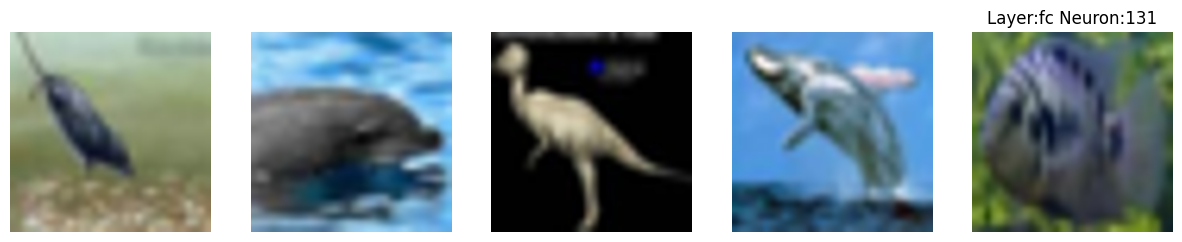


 Layer:fc Neuron:132

 Ground Truth Label: American egret, great white heron, Egretta albus
1st description: American egret, great white heron, Egretta albus, sim:3.229
2nd description: little blue heron, Egretta caerulea, sim:2.510
3rd description: spoonbill, sim:2.441
5 most highly activating images in D_probe:


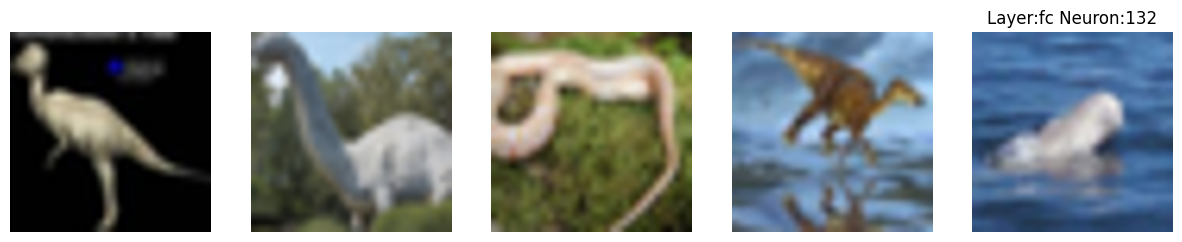

In [ ]:
# !!! YOUR CODE HERE !!!
clip_name = 'ViT-B/16'
target_name = 'resnet50'
target_layer = 'fc'
d_probe = 'cifar100_train'
concept_set = 'data/imagenet_labels.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi
ids_to_check = [131, 132]

with open('data/imagenet_labels.txt', 'r') as f:
    ground_truth_labels = (f.read()).split('\n')

utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer],
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size,
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name,
                                                             text_save_name, similarity_fn, device=device)

with open(concept_set, 'r') as f:
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

ranks = ["1st", "2nd", "3rd"]
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

for orig_id in ids_to_check:

    print('\n Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
    print('\n Ground Truth Label: {}'.format(ground_truth_labels[orig_id]))
    vals, ids = torch.topk(similarities[orig_id], k=3, largest=True)
    for i in range(len(vals)):
        print("{} description: {}, sim:{:.3f}".format(ranks[i], words[int(ids[i])], vals[i]))

    print("5 most highly activating images in D_probe:")
    fig = plt.figure(figsize=(15, 7))
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        fig.add_subplot(1, 5, i+1)
        plt.imshow(im)
        plt.axis('off')

    plt.title('Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
    plt.show()

### **(b) Extending the analysis of Fig. 4**

* Now, try to label 2 or 3 other neurons (different from the ones used above) and observe whether the results are reasonable or failure cases.

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1000/1000 [00:00<00:00, 1393.75it/s]


torch.Size([1000, 1000])
Files already downloaded and verified

 Layer:fc Neuron:0

 Ground Truth Label: tench, Tinca tinca
1st description: tench, Tinca tinca, sim:5.785
2nd description: coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch, sim:5.355
3rd description: gar, garfish, garpike, billfish, Lepisosteus osseus, sim:4.146
5 most highly activating images in D_probe:


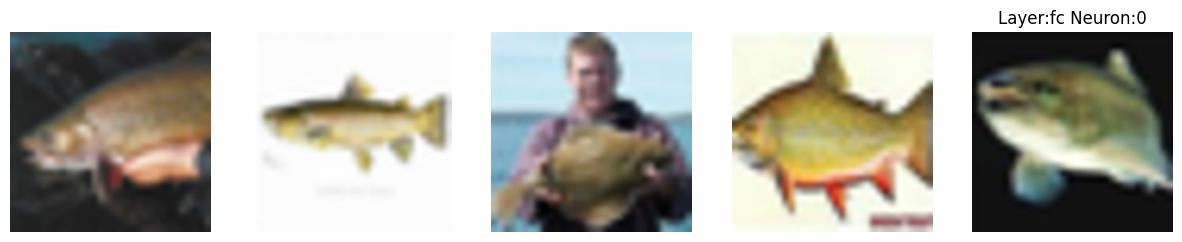


 Layer:fc Neuron:1

 Ground Truth Label: goldfish, Carassius auratus
1st description: anemone fish, sim:6.694
2nd description: goldfish, Carassius auratus, sim:6.660
3rd description: tench, Tinca tinca, sim:5.304
5 most highly activating images in D_probe:


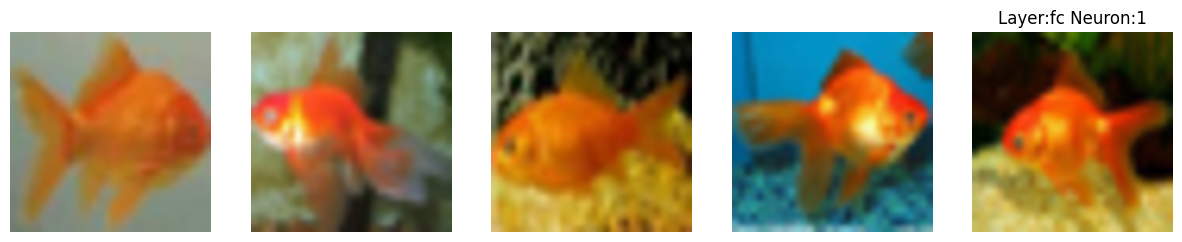


 Layer:fc Neuron:2

 Ground Truth Label: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
1st description: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias, sim:6.013
2nd description: tiger shark, Galeocerdo cuvieri, sim:5.556
3rd description: hammerhead, hammerhead shark, sim:5.377
5 most highly activating images in D_probe:


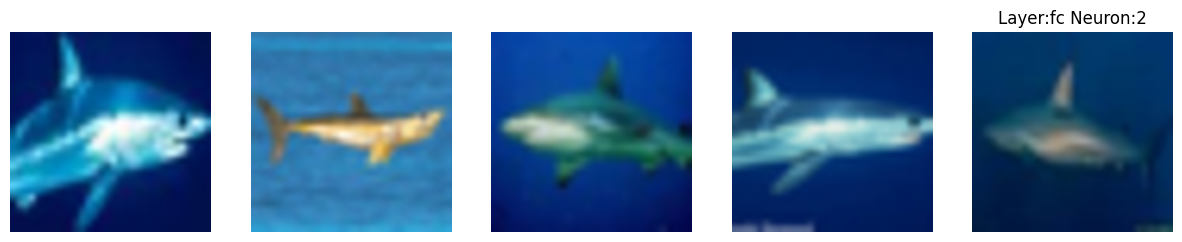

In [ ]:
# !!! YOUR CODE HERE !!!

with open('data/imagenet_labels.txt', 'r') as f:
    ground_truth_labels = (f.read()).split('\n')

ids_to_check = [0, 1, 2]

# print(ground_truth_labels[0])

utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer],
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size,
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name,
                                                             text_save_name, similarity_fn, device=device)

with open(concept_set, 'r') as f:
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

ranks = ["1st", "2nd", "3rd"]
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

for orig_id in ids_to_check:

    print('\n Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
    print('\n Ground Truth Label: {}'.format(ground_truth_labels[orig_id]))
    vals, ids = torch.topk(similarities[orig_id], k=3, largest=True)
    for i in range(len(vals)):
        print("{} description: {}, sim:{:.3f}".format(ranks[i], words[int(ids[i])], vals[i]))

    print("5 most highly activating images in D_probe:")
    fig = plt.figure(figsize=(15, 7))
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        fig.add_subplot(1, 5, i+1)
        plt.imshow(im)
        plt.axis('off')

    plt.title('Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
    plt.show()

### **(c) Analysis of Results**

* Briefly comment on the results from parts (a) and (b). For example, are the results same as the paper? and what extra observations did you make from part (b)?

My results from part (a) were exactly the same as the results in the paper. Although I don't have much knowledge on birds and did not personally know how to label the images as correct or incorrect, after making sure to print out the ground truth class, I was able to check that it was the same classification as the results in the paper. As for part (b), I just decided to check the labels for the first three neurons. From looking up what a tench looks like, it seems like the first classification was successful. The second neuron is definitely successful as all the images look like goldfish. The third classification seems mostly successful; I just think that the second image does not look like a great white shark but the last three images definitely do.

---
---